# Model and Dataset exploration using Streamlit

In [3]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import f_regression
import itertools

In [2]:
RANDOM_STATE = 42

## Feature Engineering

In [12]:
# Constant
drop_cols = []
obj_col = "target"
df_path = "data/heart.csv"
df = pd.read_csv(df_path)
features=df.drop(columns=['target' ])


## feature engineering
def feature_engineering(raw_df):
    #print(f'Original_df_shape = {df.shape}')
    target = raw_df[[obj_col]]
    corr = raw_df.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= 0.8:
                if columns[j]:
                    columns[j] = False
    selected_columns = raw_df.columns[columns]
    feature_ls = list(selected_columns)
    feature_ls.remove('target')
    features1 = df[feature_ls]
    #omit all features which have less than +-0.004 correlation with target
    corre = pd.DataFrame()
    # this not utilized
    for i in features1.columns:
        corre[i] = pearsonr(df.target, features1[i])
    corre1 = corre.T
    coore2 = corre1.iloc[:, 0].sort_values(ascending=False)
    new_features = coore2[np.abs(coore2) > 0.0004].index
    # Feature Selection based on importance

    F_values, p_values = f_regression(features, target)
    f_reg_results = list(itertools.zip_longest(features.columns, F_values, ['%.3f' % p for p in p_values]))
    f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
    f_reg_results = f_reg_results.sort_values(by=['P_Value'])
    f_reg_results.P_Value= f_reg_results.P_Value.astype(float)
    f_reg_results=f_reg_results[f_reg_results.P_Value<0.06]
    f_reg_list=f_reg_results.Variable.values
    final_features = list(set(f_reg_list) & set(new_features))
    final_data=pd.concat([df[final_features] ,target], axis=1)
    #print(f'Final_df_shape = {final_data.shape}')
    return final_data

In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
# cat
def to_category(train_df, test_df):
    cat = []
    mappings = {}
    for col in cat:
        le = preprocessing.LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return train_df, test_df, mappings

In [6]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions = 1 * (y_proba >= t)
    return y_proba, predictions

## Metrics and Plots

In [7]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

In [8]:
def get_metrics(y, ypred, yproba):
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [9]:
def get_plots(y, ypred, yproba):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm).plot()
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [10]:
# evaluation
def eval_model(clf, X, y):
    y_proba, y_pred = get_predictions(clf, X)
    metrics = get_metrics(y, y_pred, y_proba)
    plots = get_plots(y, y_pred, y_proba)
    return metrics, plots

## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation.

In [21]:
df[obj_col]

0       0
1       0
2       0
3       0
4       0
       ..
1020    1
1021    0
1022    0
1023    1
1024    0
Name: target, Length: 1025, dtype: int64

In [24]:
print("Loading data...")
df_train = pd.read_csv(df_path)#.drop('target',axis=1)
#df_test = pd.read_csv(test_df_path)

print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
# test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
# train_df, test_df, mappings = to_category(train_df, test_df)

Loading data...
Engineering features...


/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
train_df

,cp,ca,trestbps,thal,age,oldpeak,thalach,exang,sex,slope,restecg,chol
0,0,2,125,3,52,1.0,168,0,1,2,1,212
1,0,0,140,3,53,3.1,155,1,1,0,0,203
2,0,0,145,3,70,2.6,125,1,1,0,1,174
3,0,1,148,3,61,0.0,161,0,1,2,1,203
4,0,3,138,2,62,1.9,106,0,0,1,1,294
...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,0,140,2,59,0.0,164,1,1,2,1,221
1021,0,1,125,3,60,2.8,141,1,1,1,0,258
1022,0,1,110,2,47,1.0,118,1,1,1,0,275
1023,0,0,110,2,50,0.0,159,0,0,2,0,254


Here are the features in the data:

```
Age (age in years)
Sex (1 = male; 0 = female)
CP (chest pain type)
TRESTBPS (resting blood pressure (in mm Hg on admission to the hospital))
CHOL (serum cholestoral in mg/dl)
FPS (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
RESTECH (resting electrocardiographic results)
THALACH (maximum heart rate achieved)
EXANG (exercise induced angina (1 = yes; 0 = no))
OLDPEAK (ST depression induced by exercise relative to rest)
SLOPE (the slope of the peak exercise ST segment)
CA (number of major vessels (0-3) colored by flourosopy)
THAL (3 = normal; 6 = fixed defect; 7 = reversable defect)
TARGET (1 or 0)
```

In [69]:
mappings = {
    'sex':{'female':0 , 'male':1},
    'cp':{'cp1':0,'cp2':1,'cp3':2,'cp4':3},
    'fps':{'True':1,'False':0},
    'exang':{'Yes':1,'No':0}
}

In [70]:
mappings

{'sex': {'female': 0, 'male': 1},
 'cp': {'cp1': 0, 'cp2': 1, 'cp3': 2, 'cp4': 3},
 'fps': {'True': 1, 'False': 0},
 'exang': {'Yes': 1, 'No': 0}}

## Some EDA

In [29]:
df_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


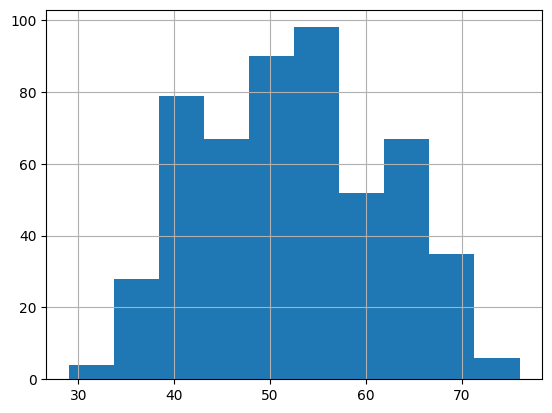

In [32]:
df_train[df_train.target == 1].age.hist()
plt.show()

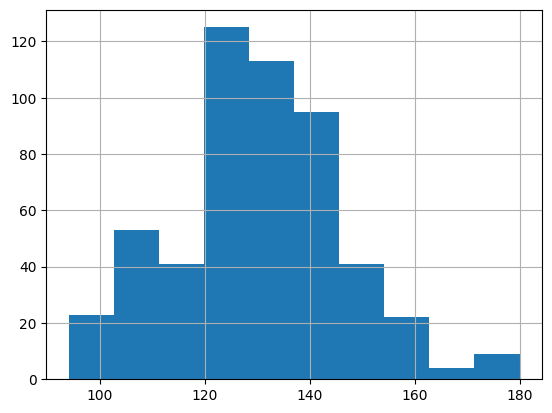

In [33]:
df_train[df_train.target == 1].trestbps.hist()
plt.show()

In [36]:
train_df = train_df.fillna(0)
#

In [37]:
train_df.head()

,cp,ca,trestbps,thal,age,oldpeak,thalach,exang,sex,slope,restecg,chol
0,0,2,125,3,52,1.0,168,0,1,2,1,212
1,0,0,140,3,53,3.1,155,1,1,0,0,203
2,0,0,145,3,70,2.6,125,1,1,0,1,174
3,0,1,148,3,61,0.0,161,0,1,2,1,203
4,0,3,138,2,62,1.9,106,0,0,1,1,294


In [38]:
train_df.describe()

,cp,ca,trestbps,thal,age,oldpeak,thalach,exang,sex,slope,restecg,chol
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000
mean,0.942439,0.754146,131.611707,2.323902,54.434146,1.071512,149.114146,0.336585,0.695610,1.385366,0.529756,246.00000
std,1.029641,1.030798,17.516718,0.620660,9.072290,1.175053,23.005724,0.472772,0.460373,0.617755,0.527878,51.59251
min,0.000000,0.000000,94.000000,0.000000,29.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,126.00000
25%,0.000000,0.000000,120.000000,2.000000,48.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,211.00000
50%,1.000000,0.000000,130.000000,2.000000,56.000000,0.800000,152.000000,0.000000,1.000000,1.000000,1.000000,240.00000
75%,2.000000,1.000000,140.000000,3.000000,61.000000,1.800000,166.000000,1.000000,1.000000,2.000000,1.000000,275.00000
max,3.000000,4.000000,200.000000,3.000000,77.000000,6.200000,202.000000,1.000000,1.000000,2.000000,2.000000,564.00000


## Model Training

We abuse the word test here: we really mean validation.

In [40]:
print("Training model...")
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

Training model...


In [41]:
def fit_model(train_X, train_y, max_depth=None, random_state=42):
    clf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, random_state=random_state)
    clf.fit(train_X, train_y)
    return clf

In [42]:
model = fit_model(X_train, y_train)

We save the model using joblib

In [43]:
print("Saving trained model...")
joblib.dump(model, "model.joblib")
print(type(model).__name__)
print(model.get_params())

Saving trained model...
RandomForestClassifier
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Inference

And we can carry out inference with a rehydrated model:

In [44]:
rehydrated = joblib.load("model.joblib")
type(rehydrated)

sklearn.ensemble._forest.RandomForestClassifier

In [45]:
df[:3]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [67]:
df[:3]#.shape

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [86]:
train_df.describe()

,cp,ca,trestbps,thal,age,oldpeak,thalach,exang,sex,slope,restecg,chol
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000
mean,0.942439,0.754146,131.611707,2.323902,54.434146,1.071512,149.114146,0.336585,0.695610,1.385366,0.529756,246.00000
std,1.029641,1.030798,17.516718,0.620660,9.072290,1.175053,23.005724,0.472772,0.460373,0.617755,0.527878,51.59251
min,0.000000,0.000000,94.000000,0.000000,29.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,126.00000
25%,0.000000,0.000000,120.000000,2.000000,48.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,211.00000
50%,1.000000,0.000000,130.000000,2.000000,56.000000,0.800000,152.000000,0.000000,1.000000,1.000000,1.000000,240.00000
75%,2.000000,1.000000,140.000000,3.000000,61.000000,1.800000,166.000000,1.000000,1.000000,2.000000,1.000000,275.00000
max,3.000000,4.000000,200.000000,3.000000,77.000000,6.200000,202.000000,1.000000,1.000000,2.000000,2.000000,564.00000


In [87]:
train_df.thal.value_counts(
)

2    544
3    410
1     64
0      7
Name: thal, dtype: int64

In [72]:
# {
#     'Sex':{'female':0 , 'male':1},
#     'CP':{'cp1':0,'cp2':1,'cp3':2,'cp4':3},
#     'FPS':{'True':1,'False':0},
#     'EXANG':{'Yes':1,'No':0}
# }
data_to_predict = dict(
    cp='cp1',
    ca=2,
    trestbps=143,
    thal=3,
    age=60,
    oldpeak=2.2,
    thalach=168,
    exang='Yes',
    sex='female',
    slope=2,
    restecg=1,
    chol=210
)

for k in data_to_predict:
    if k in ['sex', 'cp', 'fps', 'exang']:
        data_to_predict[k] = mappings[k][data_to_predict[k]]
data_to_predict


{'cp': 0,
 'ca': 2,
 'trestbps': 143,
 'thal': 3,
 'age': 60,
 'oldpeak': 2.2,
 'thalach': 168,
 'exang': 1,
 'sex': 0,
 'slope': 2,
 'restecg': 1,
 'chol': 210}

In [73]:
inputX = np.array(list(data_to_predict.values()))
inputX.reshape(1, -1)

array([[  0. ,   2. , 143. ,   3. ,  60. ,   2.2, 168. ,   1. ,   0. ,
          2. ,   1. , 210. ]])

In [74]:
rehydrated.predict(inputX.reshape(1, -1))

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])

In [75]:
rehydrated.predict(X_test)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,

## Metrics

Evaluating model...
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


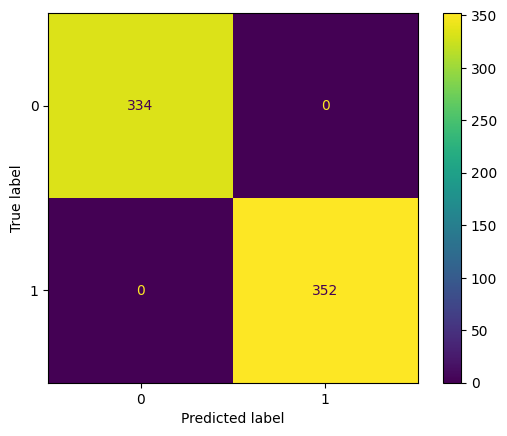

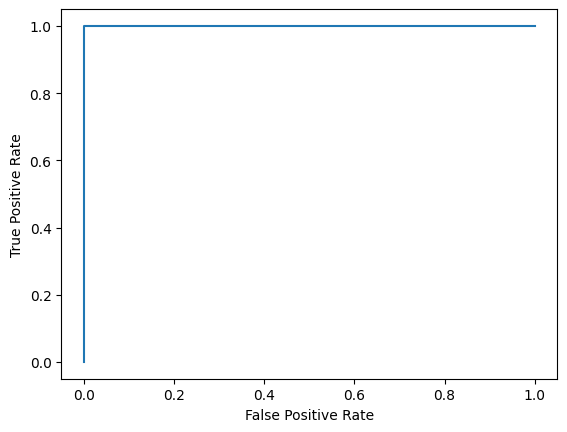

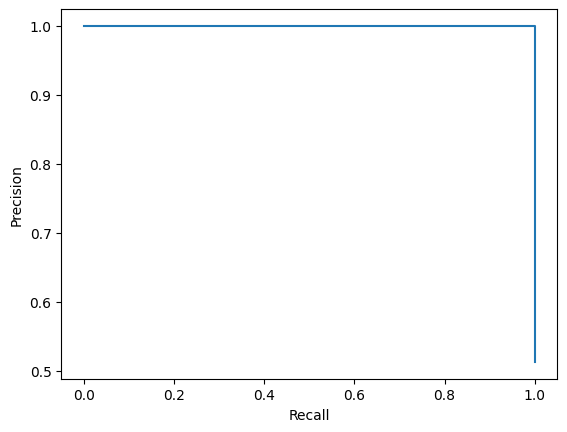

In [76]:
print("Evaluating model...")
train_metrics, train_plots = eval_model(model, X_train, y_train)
print("Train metrics:")
print(train_metrics)

In [77]:
for k in train_plots:
    print(k)
    f = train_plots[k]
    f.figure_.savefig(f"train_{k}.png")

cm
roc
pr


Test metrics:
{'roc_auc': 0.9983281086729363, 'average_precision': 0.9985480943738657, 'accuracy': 0.9911504424778761, 'precision': 1.0, 'recall': 0.9827586206896551, 'f1': 0.9913043478260869, 'cm': array([[165,   0],
       [  3, 171]])}


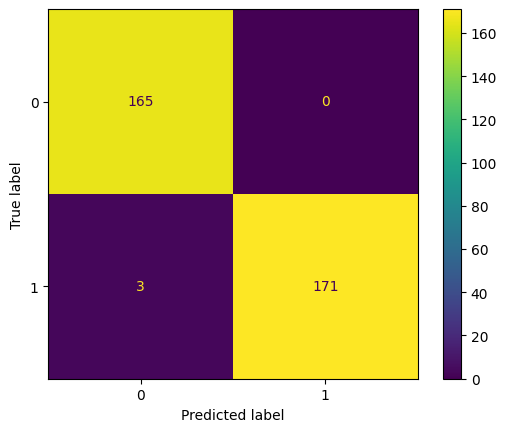

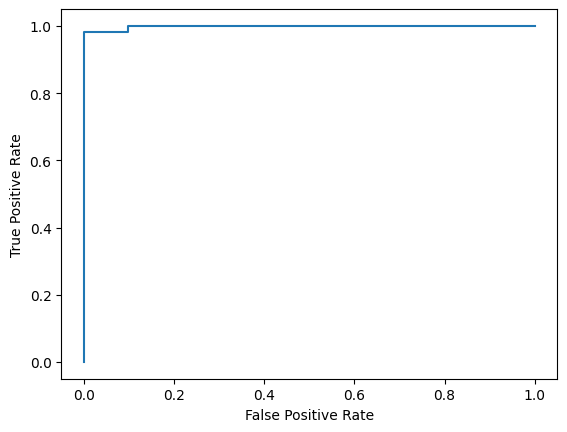

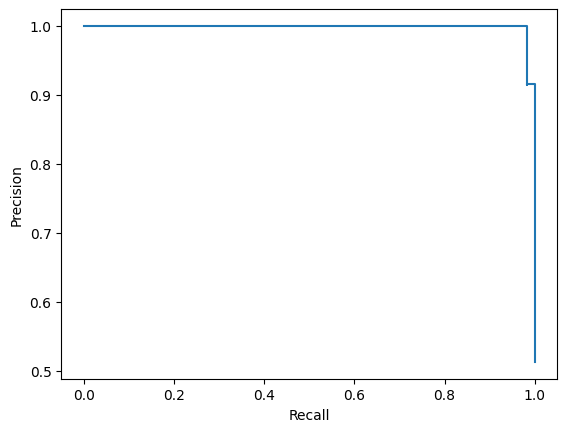

In [78]:
test_metrics, test_plots = eval_model(model, X_test, y_test)
print("Test metrics:")
print(test_metrics)

In [79]:
for k in test_plots:
    print(k)
    f = train_plots[k]
    f.figure_.savefig(f"test_{k}.png")

cm
roc
pr


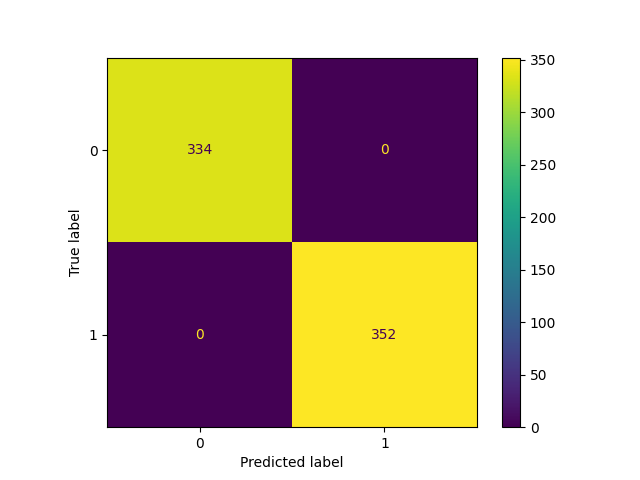

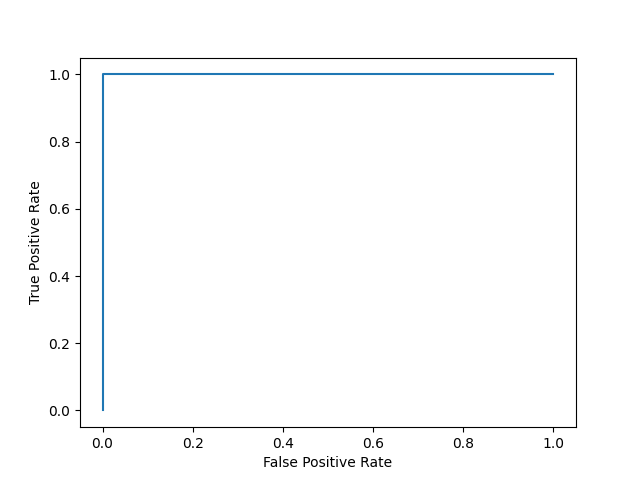

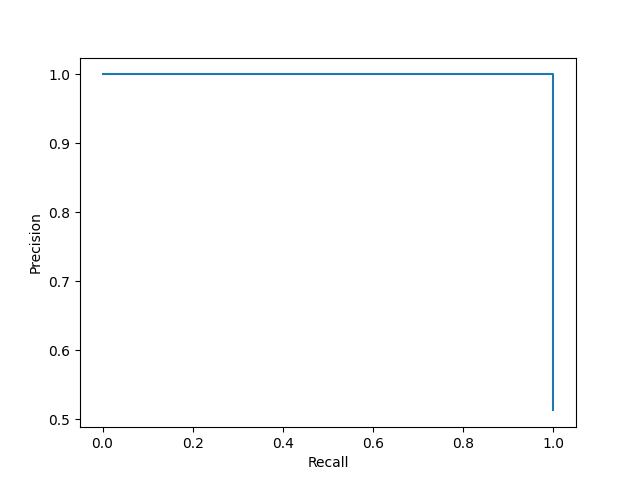

In [80]:
from IPython.display import Image, display

for k in test_plots:
    display(Image(f"test_{k}.png"))

## Now train with systematic hyperparameters

In [81]:
import uuid

In [82]:
!ls

Data              pages             test_cm.png       train_pr.png
Intro.py          plots             test_pr.png       train_roc.png
model.joblib      results.csv       test_roc.png
models            simplemodel.ipynb train_cm.png


Training Model 1
Evaluating Model
Train metrics:
{'roc_auc': 0.9109749251497006, 'average_precision': 0.9055562323149229, 'accuracy': 0.8411078717201166, 'precision': 0.8107416879795396, 'recall': 0.9005681818181818, 'f1': 0.8532974427994616, 'cm': array([[260,  74],
       [ 35, 317]])}
Test metrics:
{'roc_auc': 0.9128874956461164, 'average_precision': 0.8931629625170248, 'accuracy': 0.8525073746312685, 'precision': 0.8406593406593407, 'recall': 0.8793103448275862, 'f1': 0.8595505617977528, 'cm': array([[136,  29],
       [ 21, 153]])}
----------------------
Training Model 5
Evaluating Model
Train metrics:
{'roc_auc': 0.9932039330430049, 'average_precision': 0.9928319434248898, 'accuracy': 0.9533527696793003, 'precision': 0.9395604395604396, 'recall': 0.9715909090909091, 'f1': 0.9553072625698324, 'cm': array([[312,  22],
       [ 10, 342]])}
Test metrics:
{'roc_auc': 0.9774991292232671, 'average_precision': 0.9725731823924787, 'accuracy': 0.9469026548672567, 'precision': 0.94318181818

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/metrics/_plot/precision_recall_curve.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Test metrics:
{'roc_auc': 0.9974921630094044, 'average_precision': 0.9979101358411704, 'accuracy': 0.9911504424778761, 'precision': 1.0, 'recall': 0.9827586206896551, 'f1': 0.9913043478260869, 'cm': array([[165,   0],
       [  3, 171]])}
----------------------
Training Model 12
Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 0.9999999999999999, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}
Test metrics:
{'roc_auc': 0.9980146290491119, 'average_precision': 0.9983026621404324, 'accuracy': 0.9911504424778761, 'precision': 1.0, 'recall': 0.9827586206896551, 'f1': 0.9913043478260869, 'cm': array([[165,   0],
       [  3, 171]])}
----------------------
Training Model 15
Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}
Test metrics:
{'roc_auc': 0.9983281086729363, 'average_precis

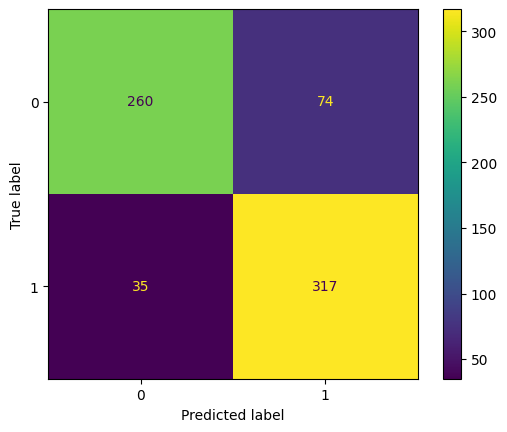

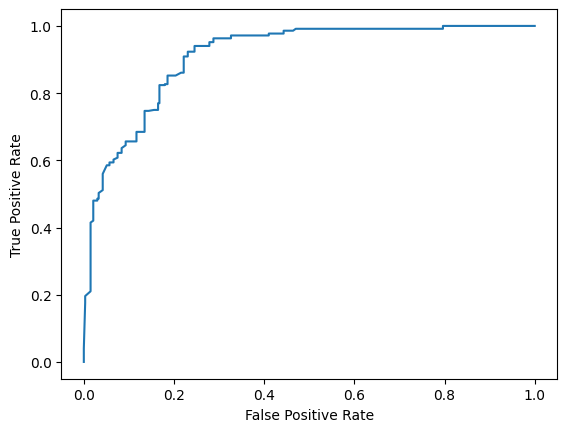

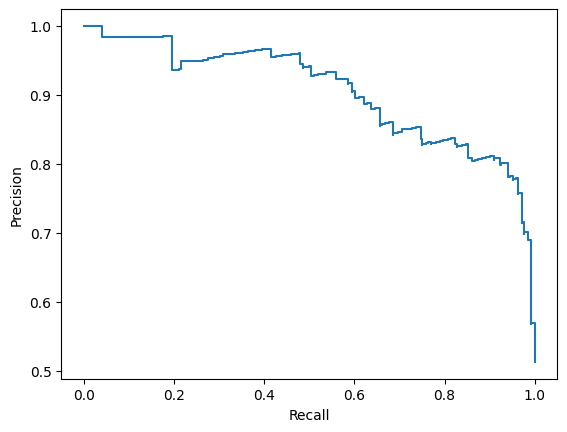

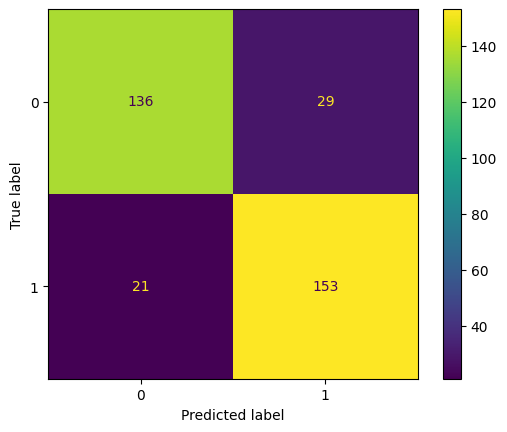

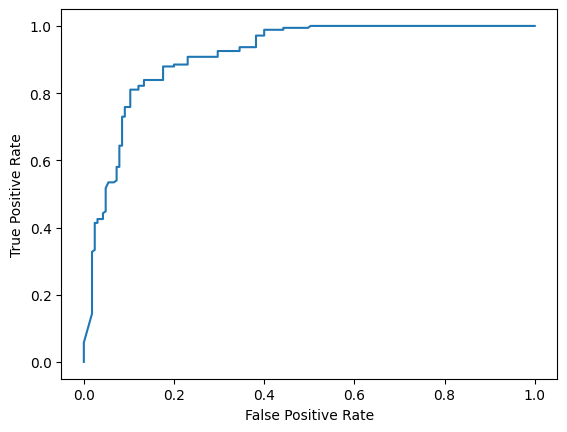

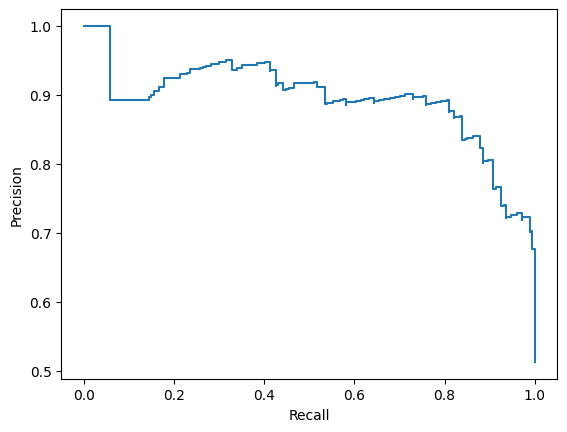

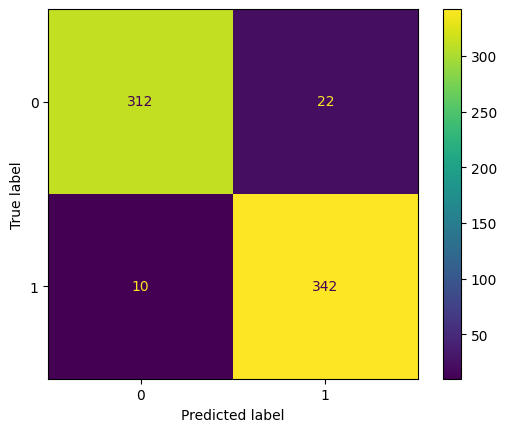

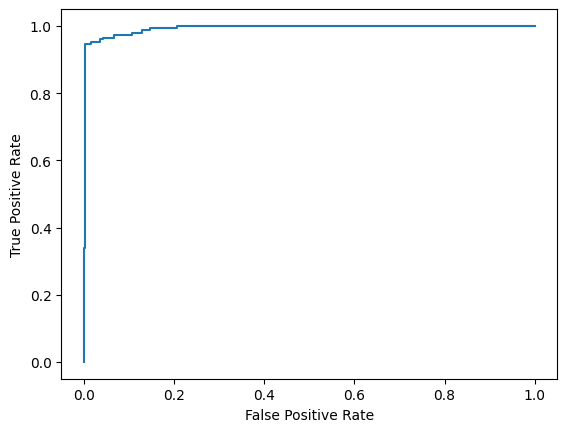

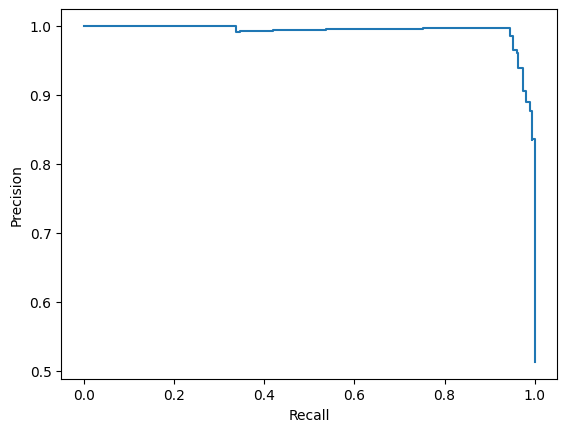

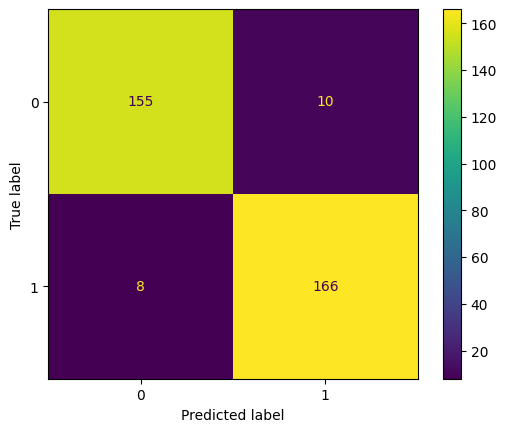

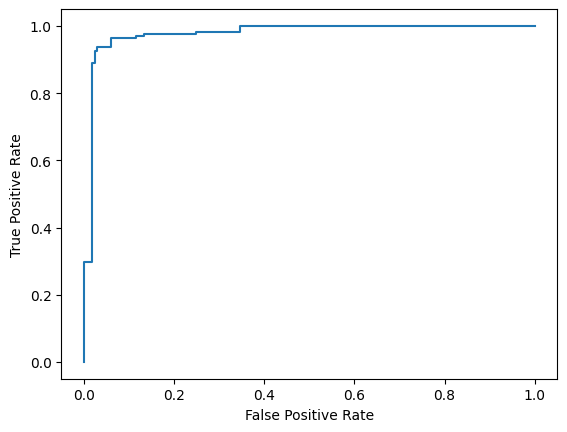

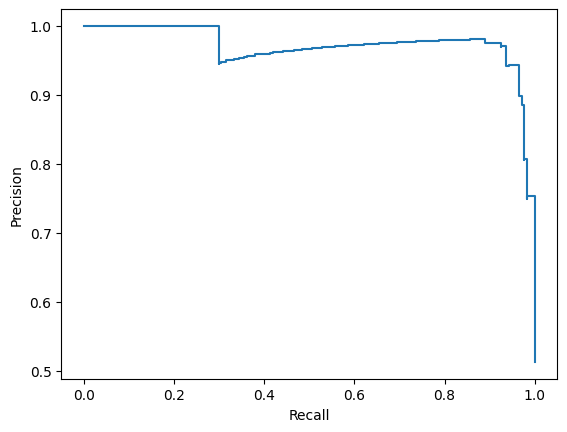

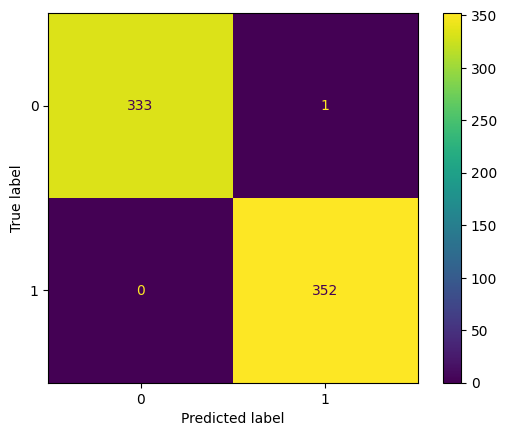

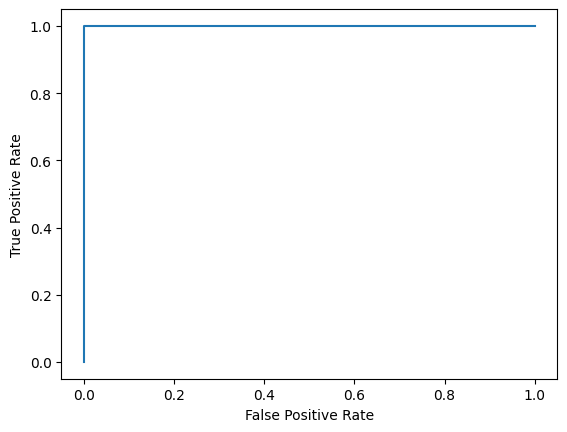

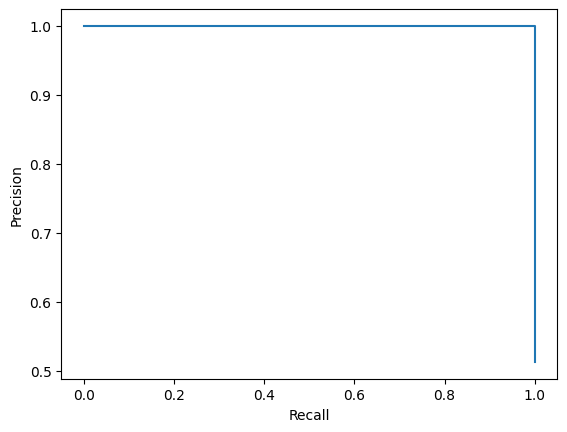

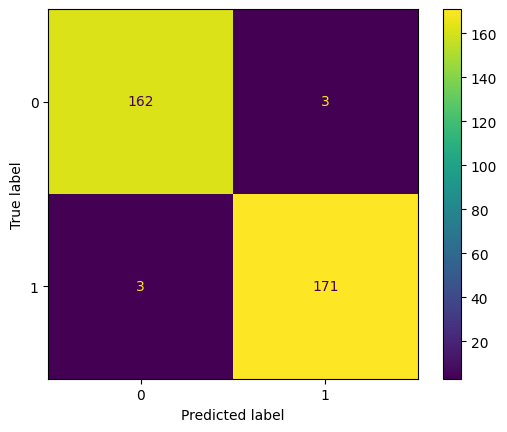

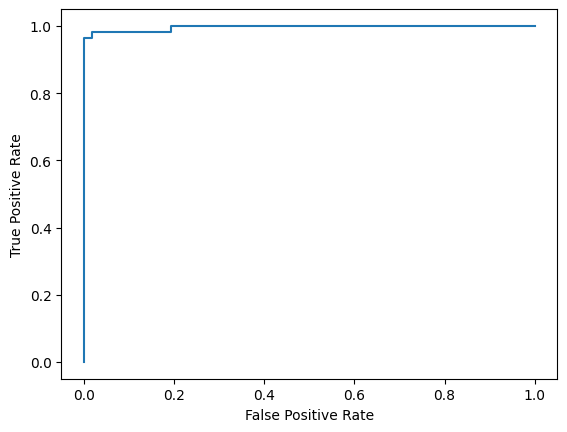

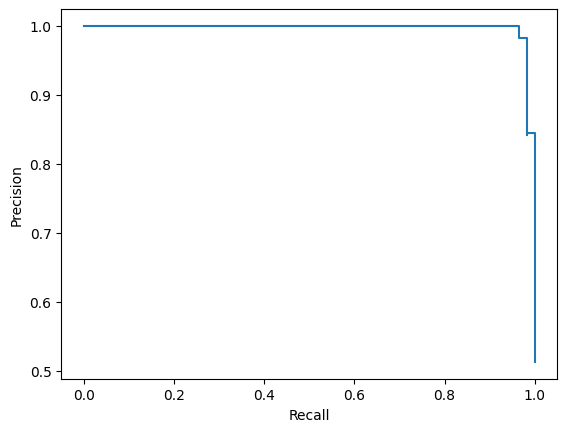

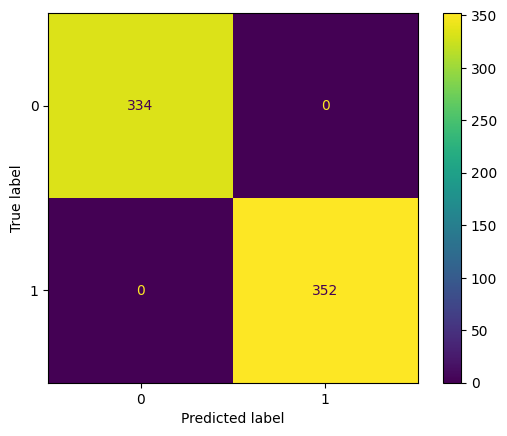

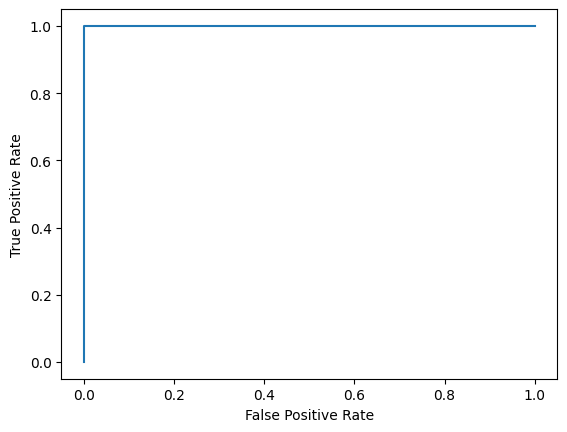

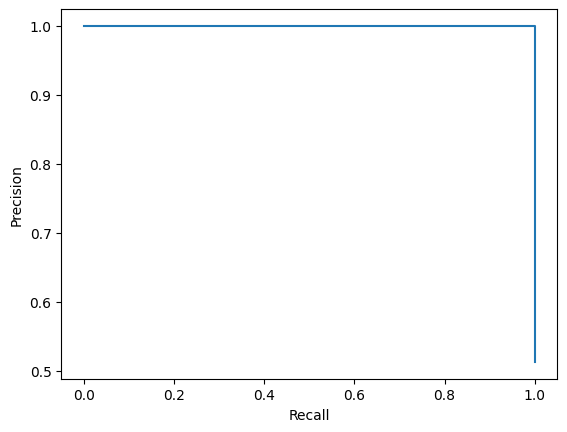

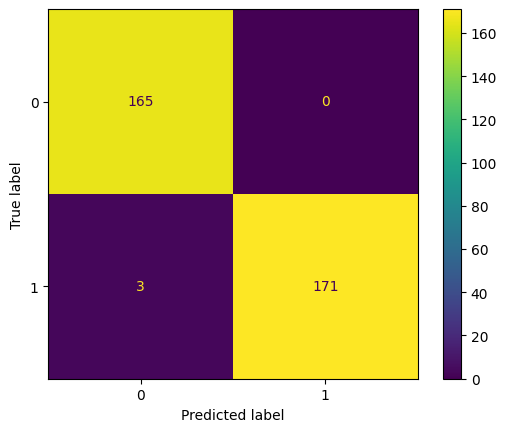

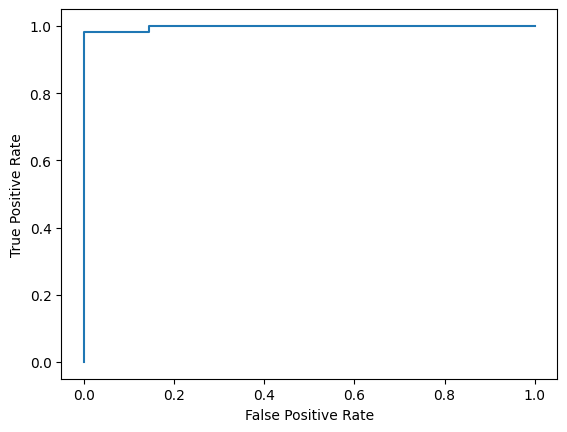

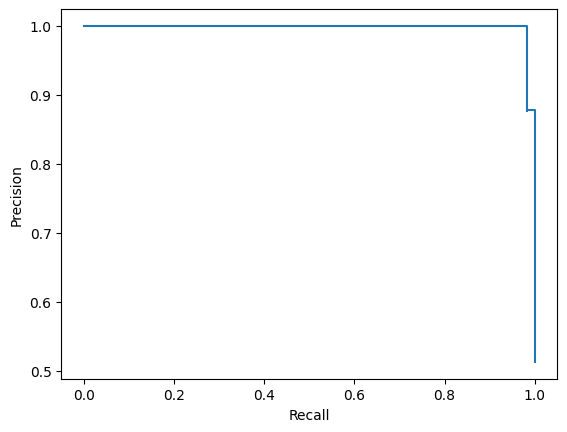

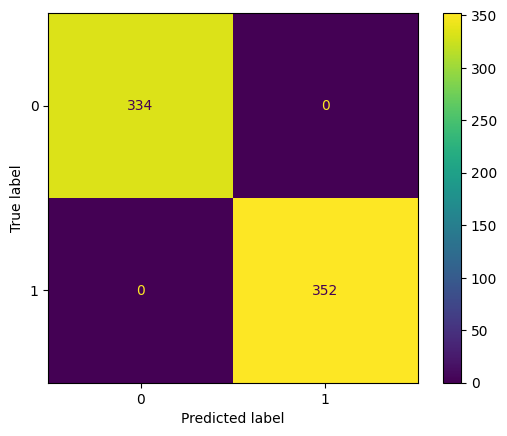

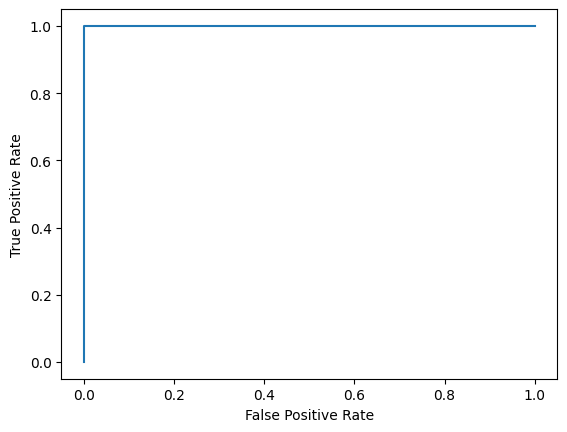

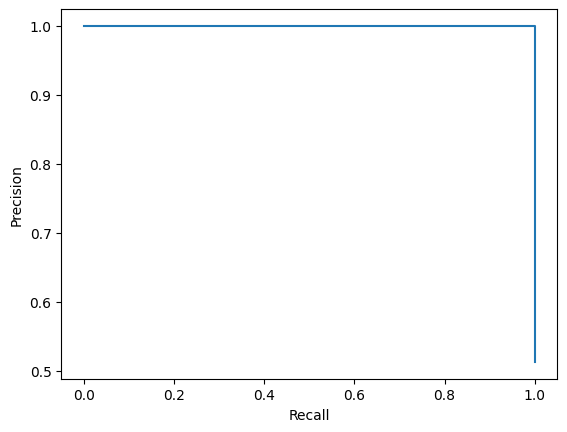

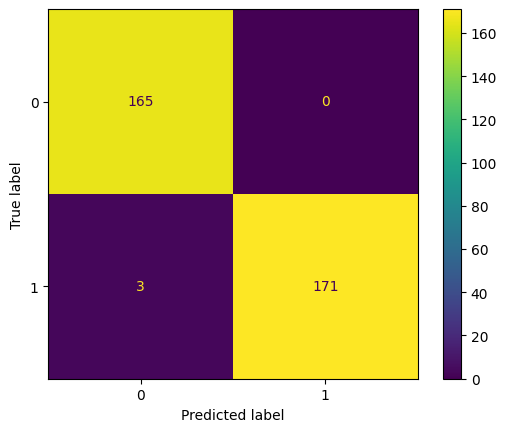

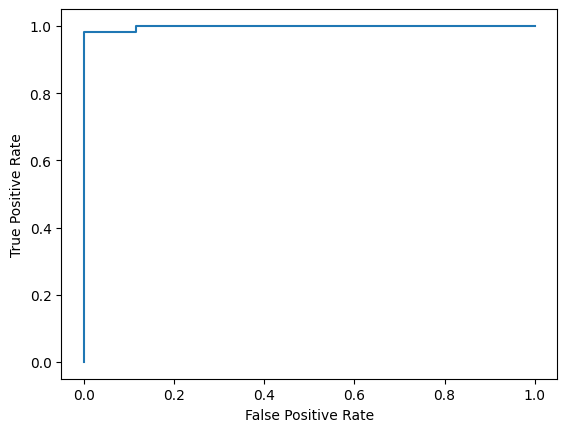

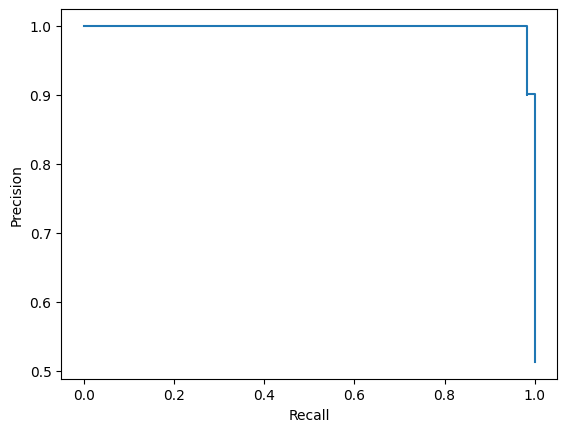

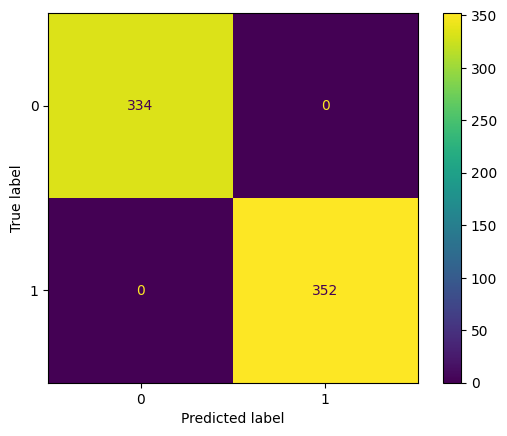

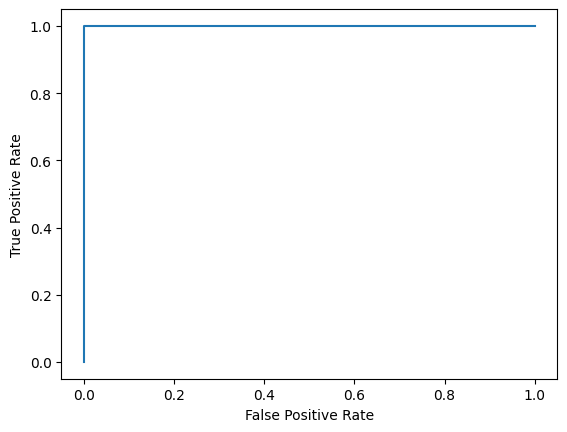

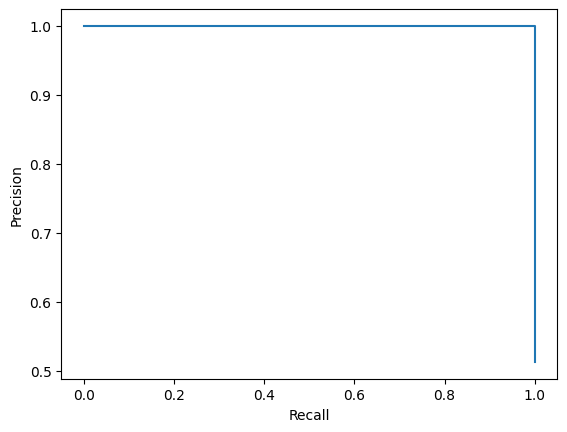

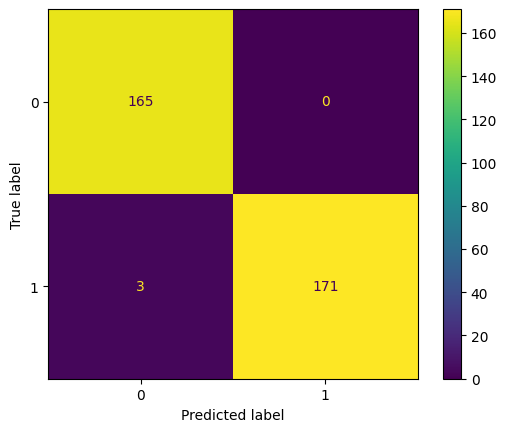

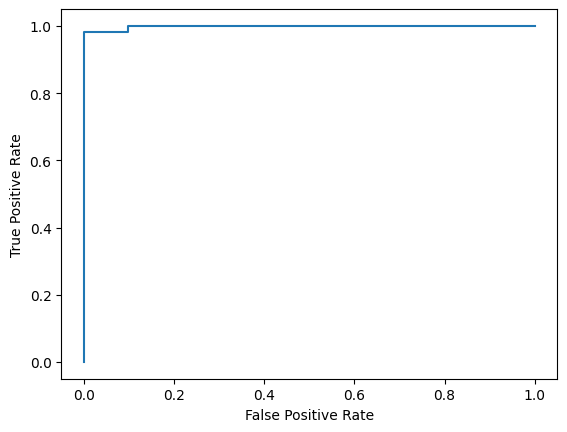

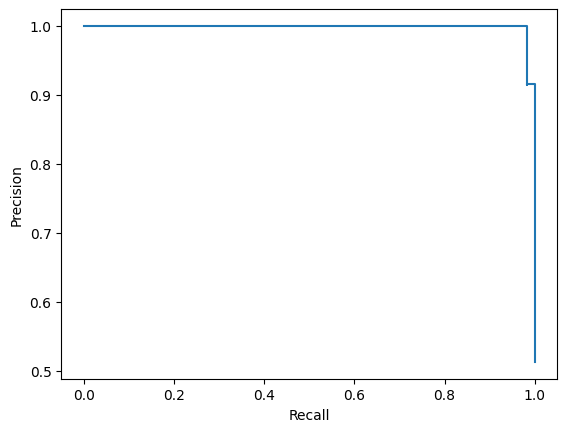

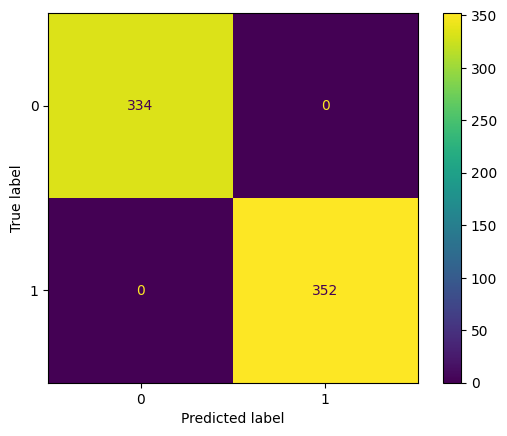

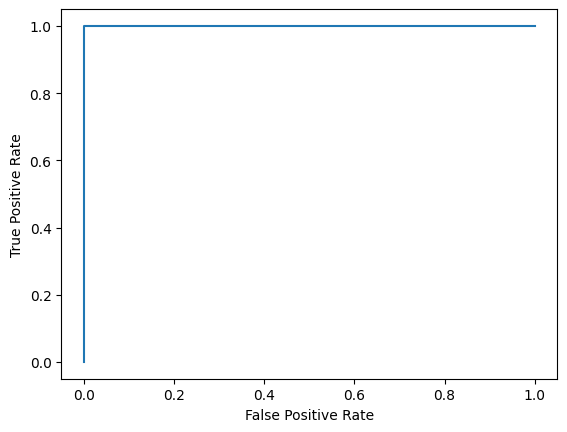

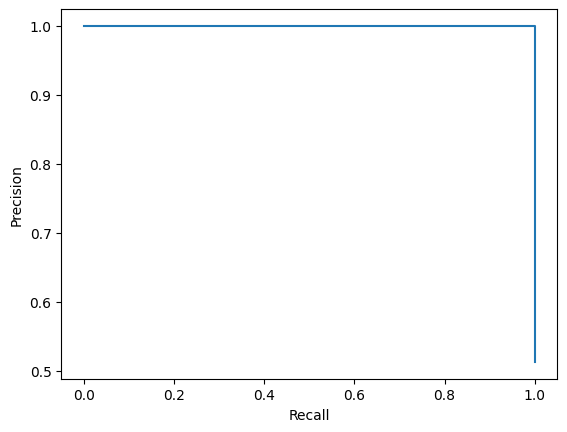

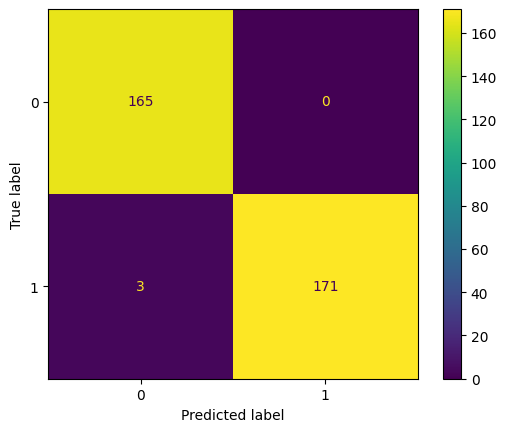

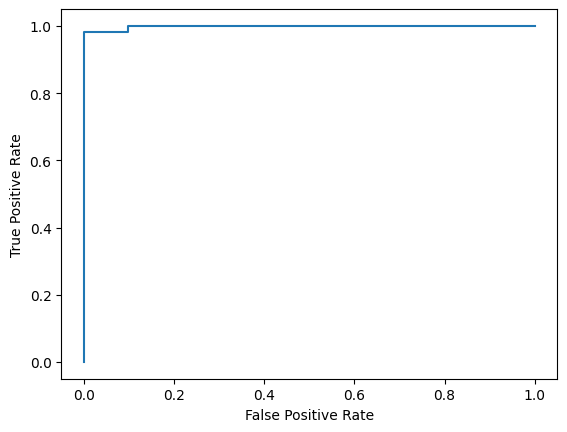

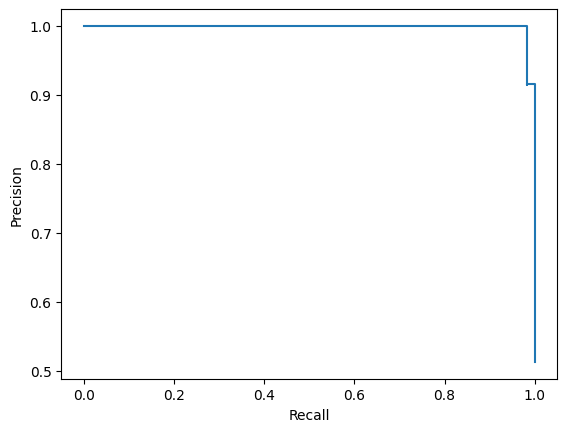

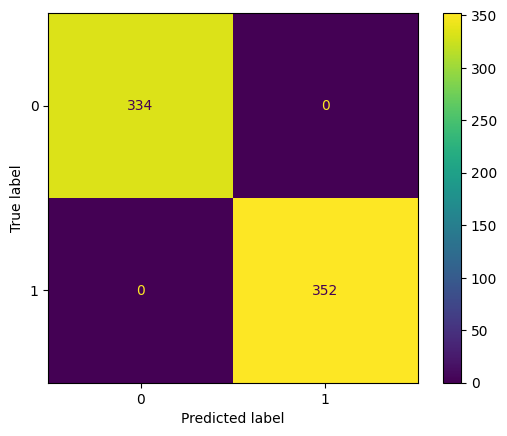

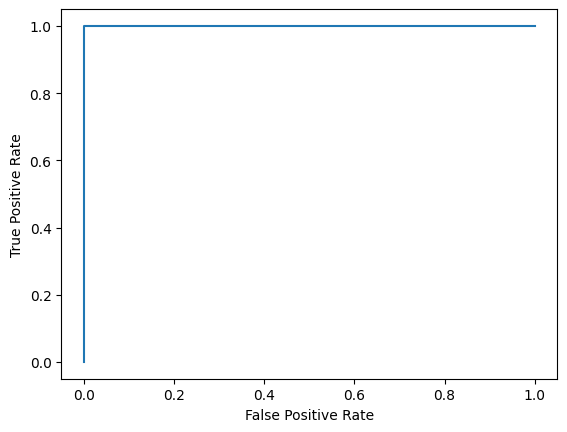

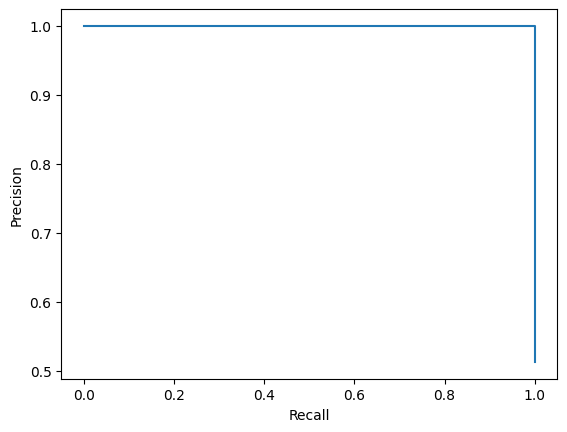

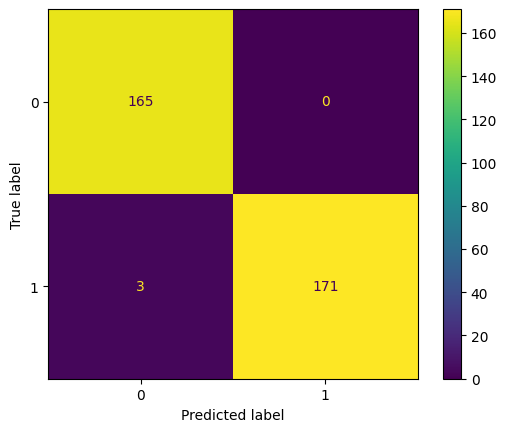

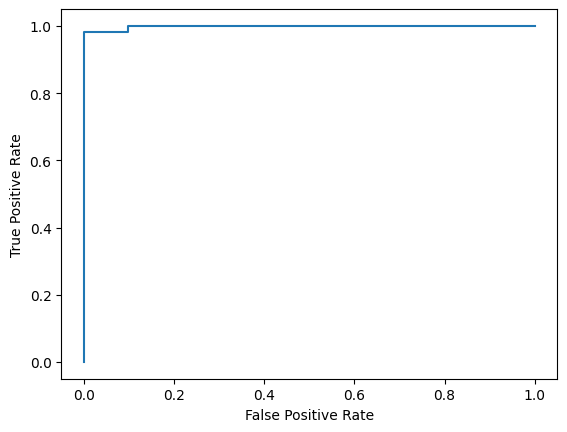

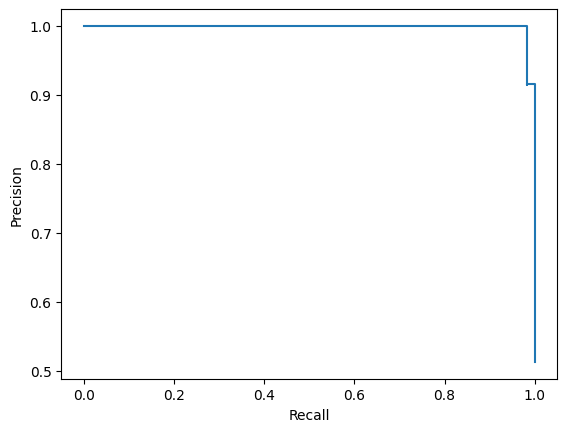

In [83]:
metrics = []
for max_depth in [1, 5, 8, 10, 12, 15, 20, None]:
    run_id = uuid.uuid4()
    print(f"Training Model {max_depth}")
    model = fit_model(X_train, y_train, max_depth=max_depth)
    print("Evaluating Model")
    train_metrics, train_plots = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_metrics)
    train_metrics['data'] = 'train'
    train_metrics['n_est'] = 200
    train_metrics['max_depth'] = max_depth
    train_metrics['run_id'] = run_id
    metrics.append(train_metrics)
    for k in train_plots:
        train_plots[k].figure_.savefig(f"plots/train_{run_id}_{k}.png")
    test_metrics, test_plots = eval_model(model, X_test, y_test)
    print("Test metrics:")
    print(test_metrics)
    test_metrics['data'] = 'test'
    test_metrics['n_est'] = 200
    test_metrics['max_depth'] = max_depth
    test_metrics['run_id'] = run_id
    metrics.append(test_metrics)
    for k in test_plots:
        test_plots[k].figure_.savefig(f"plots/test_{run_id}_{k}.png")
    joblib.dump(model, f"models/{run_id}.joblib")
    print('----------------------')

In [84]:
resudf = pd.DataFrame.from_records(metrics).set_index('run_id')
resudf

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,n_est,max_depth
run_id,,,,,,,,,,
22dfefd7-9951-4a57-b208-eebb869f83c6,0.910975,0.905556,0.841108,0.810742,0.900568,0.853297,"[[260, 74], [35, 317]]",train,200,1.0
22dfefd7-9951-4a57-b208-eebb869f83c6,0.912887,0.893163,0.852507,0.840659,0.879310,0.859551,"[[136, 29], [21, 153]]",test,200,1.0
a7ee6492-3569-408d-a6cd-30a964ed202d,0.993204,0.992832,0.953353,0.939560,0.971591,0.955307,"[[312, 22], [10, 342]]",train,200,5.0
a7ee6492-3569-408d-a6cd-30a964ed202d,0.977499,0.972573,0.946903,0.943182,0.954023,0.948571,"[[155, 10], [8, 166]]",test,200,5.0
f58045e8-0201-4cd8-88aa-fe10d6edf14f,1.000000,1.000000,0.998542,0.997167,1.000000,0.998582,"[[333, 1], [0, 352]]",train,200,8.0
f58045e8-0201-4cd8-88aa-fe10d6edf14f,0.996343,0.997024,0.982301,0.982759,0.982759,0.982759,"[[162, 3], [3, 171]]",test,200,8.0
c4bef48a-22b7-421c-83b8-8944a3fd107d,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[[334, 0], [0, 352]]",train,200,10.0
c4bef48a-22b7-421c-83b8-8944a3fd107d,0.997492,0.997910,0.991150,1.000000,0.982759,0.991304,"[[165, 0], [3, 171]]",test,200,10.0
9039a15d-9367-403a-9f10-452fa77d5b8a,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[[334, 0], [0, 352]]",train,200,12.0


In [85]:
resudf.to_csv("results.csv", header=True)